# Import modules

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import numpy as np
import seaborn
import pandas

# Data Import

In [3]:
heart_data = pandas.read_csv("data/heart.csv")

#### Data Cleaning

In [4]:
heart_data.loc[:,"ExerciseAngina"] = heart_data["ExerciseAngina"].apply(lambda x: 1 if x == "Y" else 0).astype("category")
heart_data.loc[:,"FastingBS"] = heart_data["FastingBS"].astype("category")
heart_data.loc[:,"HeartDisease"] = heart_data["HeartDisease"].astype(int)
heart_data = heart_data[heart_data["Cholesterol"] != 0]

# Exploratory Analysis

In [5]:
heart_data.head()
heart_data.info()
heart_data.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 746 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Age             746 non-null    int64   
 1   Sex             746 non-null    object  
 2   ChestPainType   746 non-null    object  
 3   RestingBP       746 non-null    int64   
 4   Cholesterol     746 non-null    int64   
 5   FastingBS       746 non-null    category
 6   RestingECG      746 non-null    object  
 7   MaxHR           746 non-null    int64   
 8   ExerciseAngina  746 non-null    category
 9   Oldpeak         746 non-null    float64 
 10  ST_Slope        746 non-null    object  
 11  HeartDisease    746 non-null    int32   
dtypes: category(2), float64(1), int32(1), int64(4), object(4)
memory usage: 62.9+ KB


,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,HeartDisease
count,746.000000,746.000000,746.000000,746.000000,746.000000,746.000000
mean,52.882038,133.022788,244.635389,140.226542,0.901609,0.477212
std,9.505888,17.282750,59.153524,24.524107,1.072861,0.499816
min,28.000000,92.000000,85.000000,69.000000,-0.100000,0.000000
25%,46.000000,120.000000,207.250000,122.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,140.000000,0.500000,0.000000
75%,59.000000,140.000000,275.000000,160.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,202.000000,6.200000,1.000000


We can see from the above that each column has the appropriate data type, and there are no empty values. So the data is sufficiently cleaned for our purposes

However, heart_data.describe() does not give us a detailed enough picture of the distribution of each column, so let's continue exploring

## Analysis of Numerical Variables

### Basic Univariate Analysis

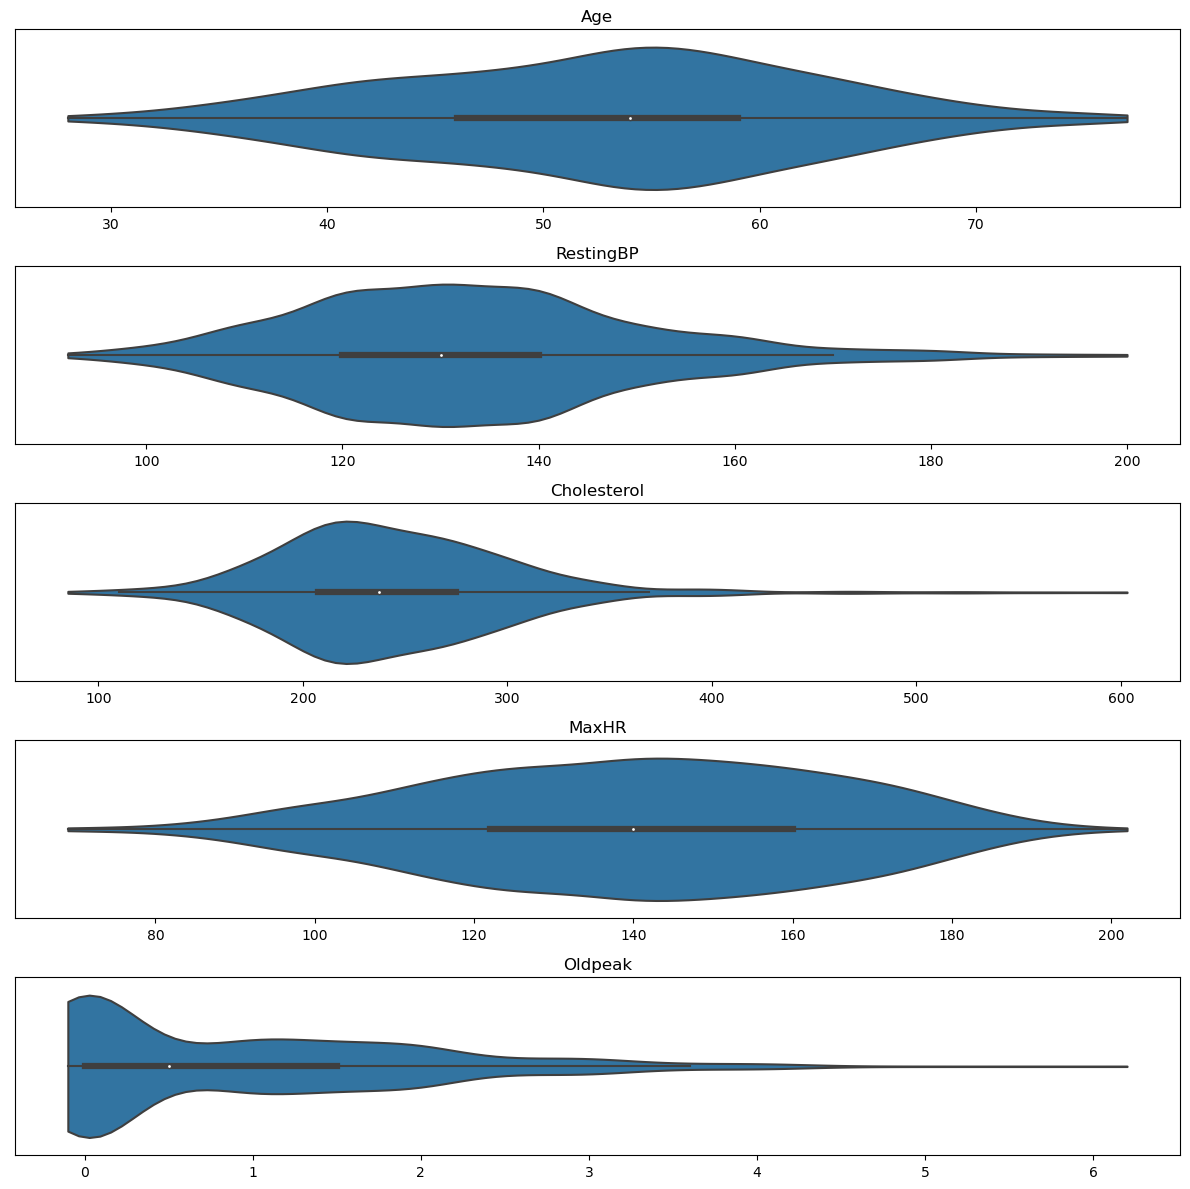

In [6]:
variables = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

fig, ax = plt.subplots(5, 1, figsize=(12, 12))

for index, variable in enumerate(variables):
    seaborn.violinplot(data=heart_data[variable], ax=ax[index], orient="h", cut=0)
    ax[index].set_title(variable)
    ax[index].set_yticklabels([])
    ax[index].set_yticks([])

fig.tight_layout()


We can now see how each of the variables are distributed. Let's see if the presence of heart disease shows us any kind of separation

### Exploring Relationship with Response Variable

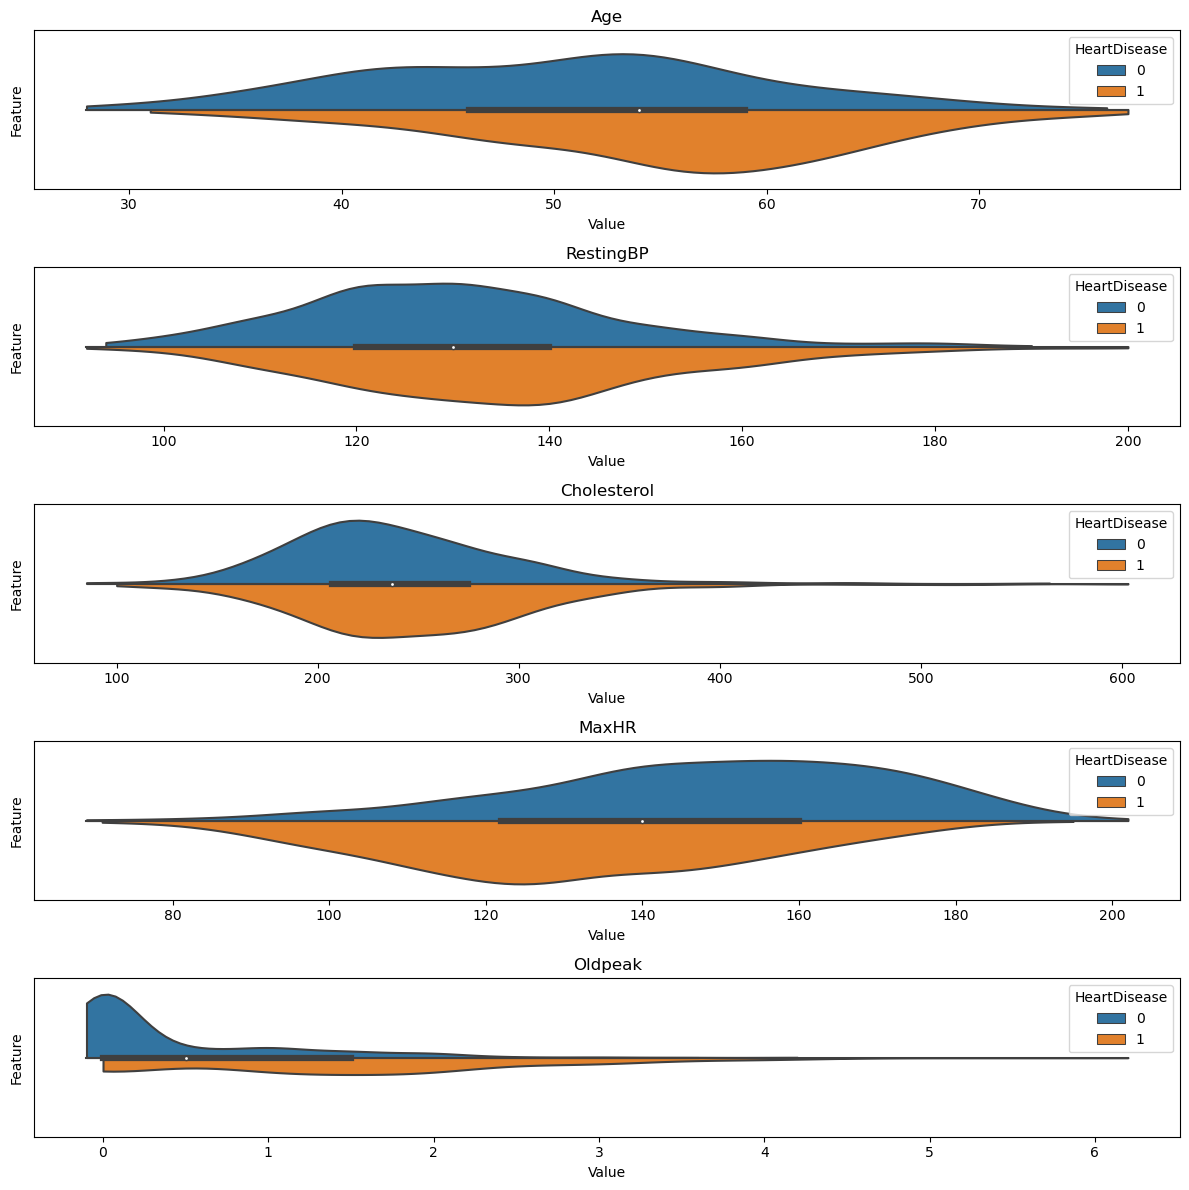

In [7]:
fig, ax = plt.subplots(5, 1, figsize=(12, 12))

for index, variable in enumerate(variables):
    plot_data = heart_data.loc[:,[variable, "HeartDisease"]].melt(id_vars="HeartDisease", var_name="Feature", value_name="Value")
    seaborn.violinplot(data=plot_data, y="Feature", x="Value", hue="HeartDisease", split=True, orient="h", cut=0, ax=ax[index])
    ax[index].set_title(variable)
    ax[index].set_yticklabels([])
    ax[index].set_yticks([])

fig.tight_layout()


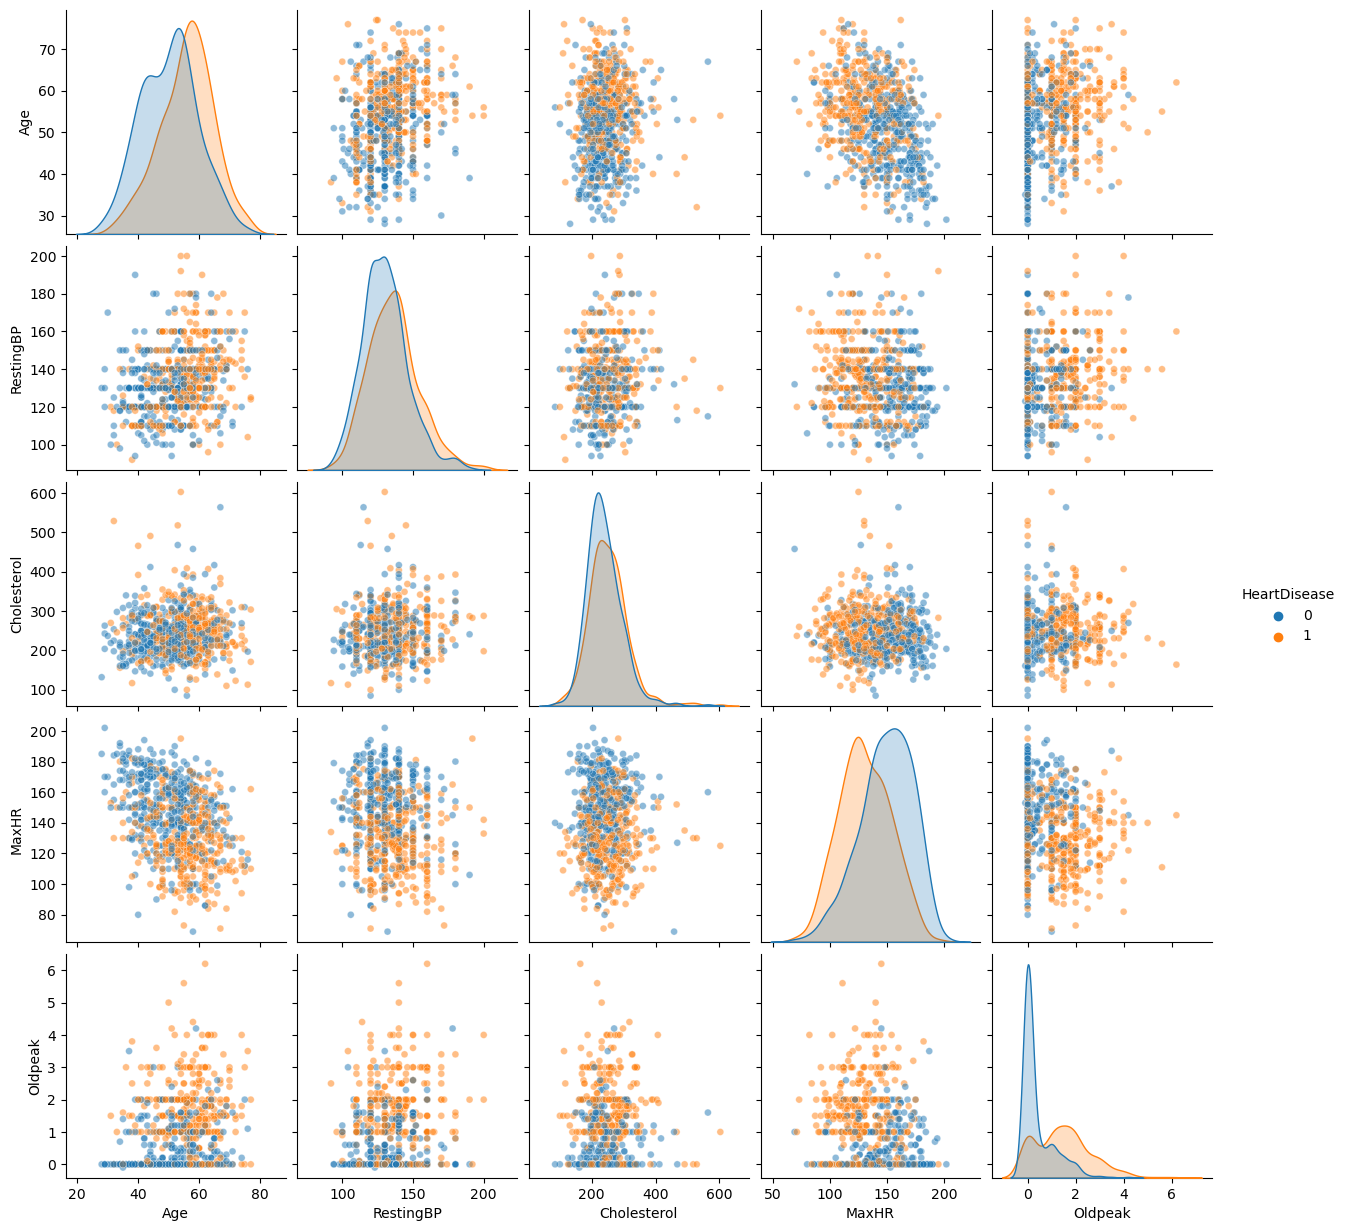

In [8]:
seaborn.pairplot(heart_data, hue="HeartDisease", vars=variables, plot_kws={"s": 25, "alpha": 0.5})
plt.show()

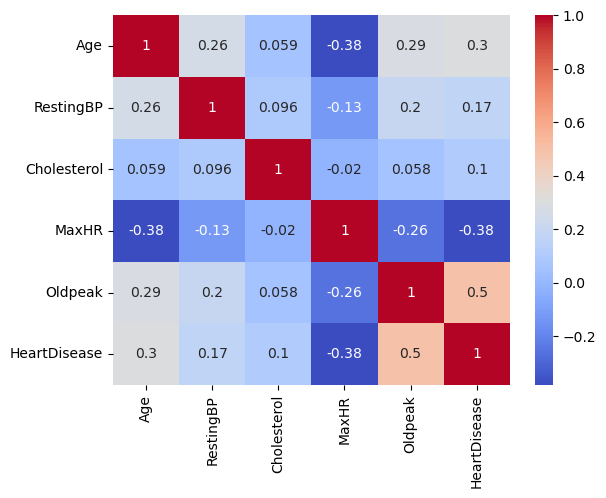

In [9]:
correlation = heart_data.corr()
seaborn.heatmap(correlation, annot=True, cmap="coolwarm")
plt.show()

From the above three plots, we can see observe some patterns
- Oldpeak, Age, and MaxHR seems to have some correlation to HeartDisease
- There seems to be increased diagonal clustering of the points for some combinaitions when two variables are taken into account, e.g. MaxHR/Age and MaxHR/OldPeak. It is also noted that these cases coincide with the fact that these varables have opposite correlation directions with our response variables.

# Analysis of Categorical Variables

### Basic Univariate Analysis

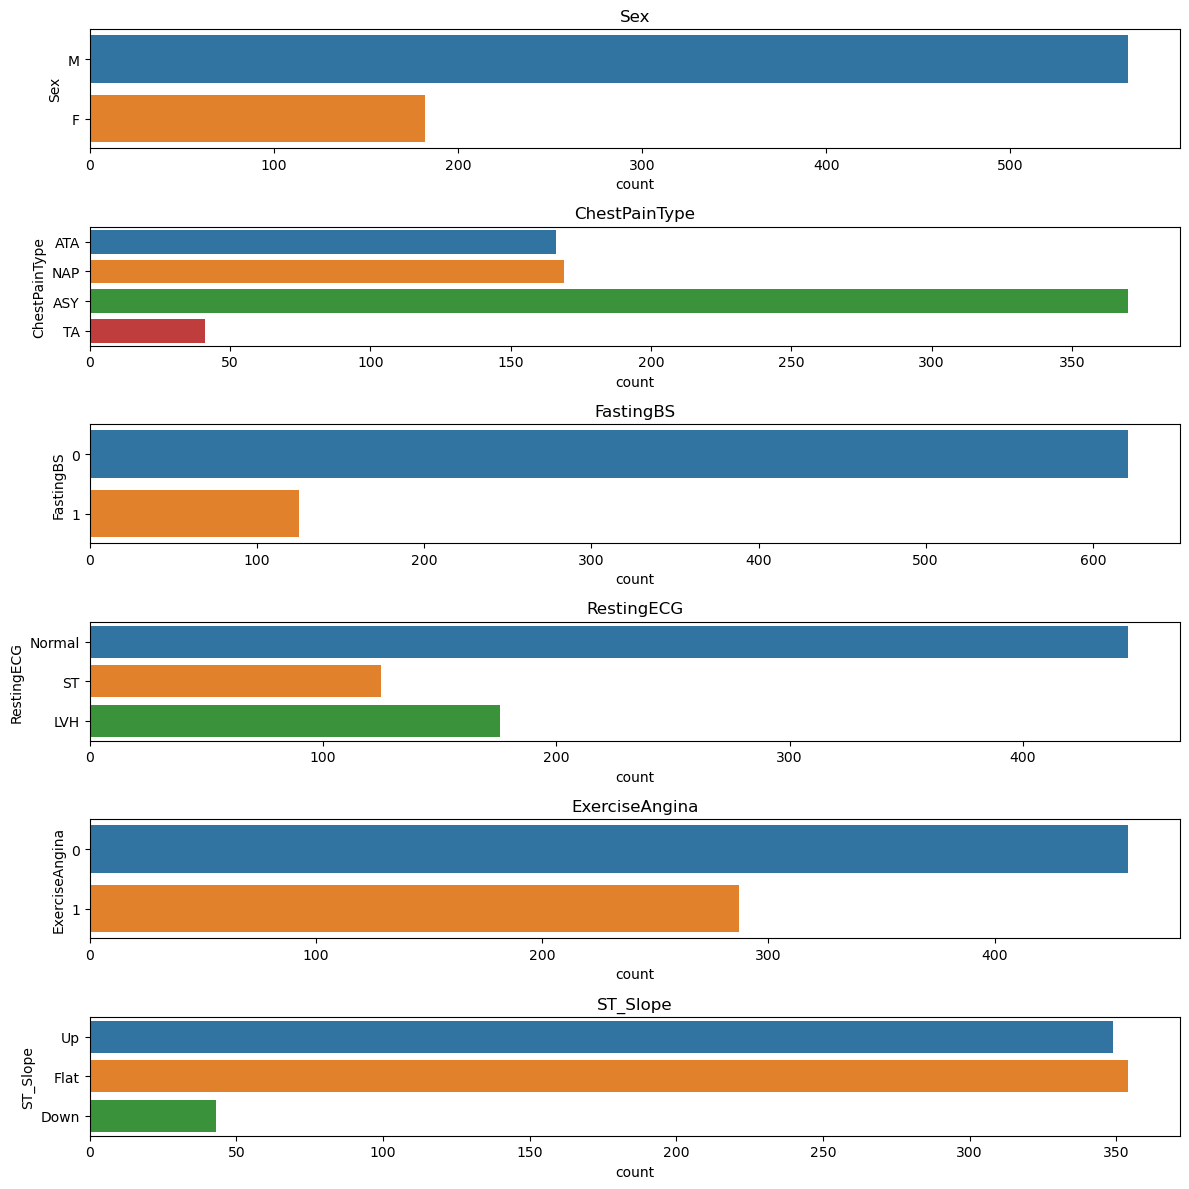

In [22]:
variables = ["Sex", "ChestPainType", "FastingBS", "RestingECG", "ExerciseAngina", "ST_Slope"]

fig, ax = plt.subplots(6, 1, figsize=(12, 12))

for index, variable in enumerate(variables):
    seaborn.countplot(data=heart_data, y=variable, ax=ax[index])
    ax[index].set_title(variable)

fig.tight_layout()

The above gives us a fairly clear picture of the distribution of categorical variables, again, let's see if seperating the data by HeartDisease shows us any patterns

### Exploring Relationship with Response Variable

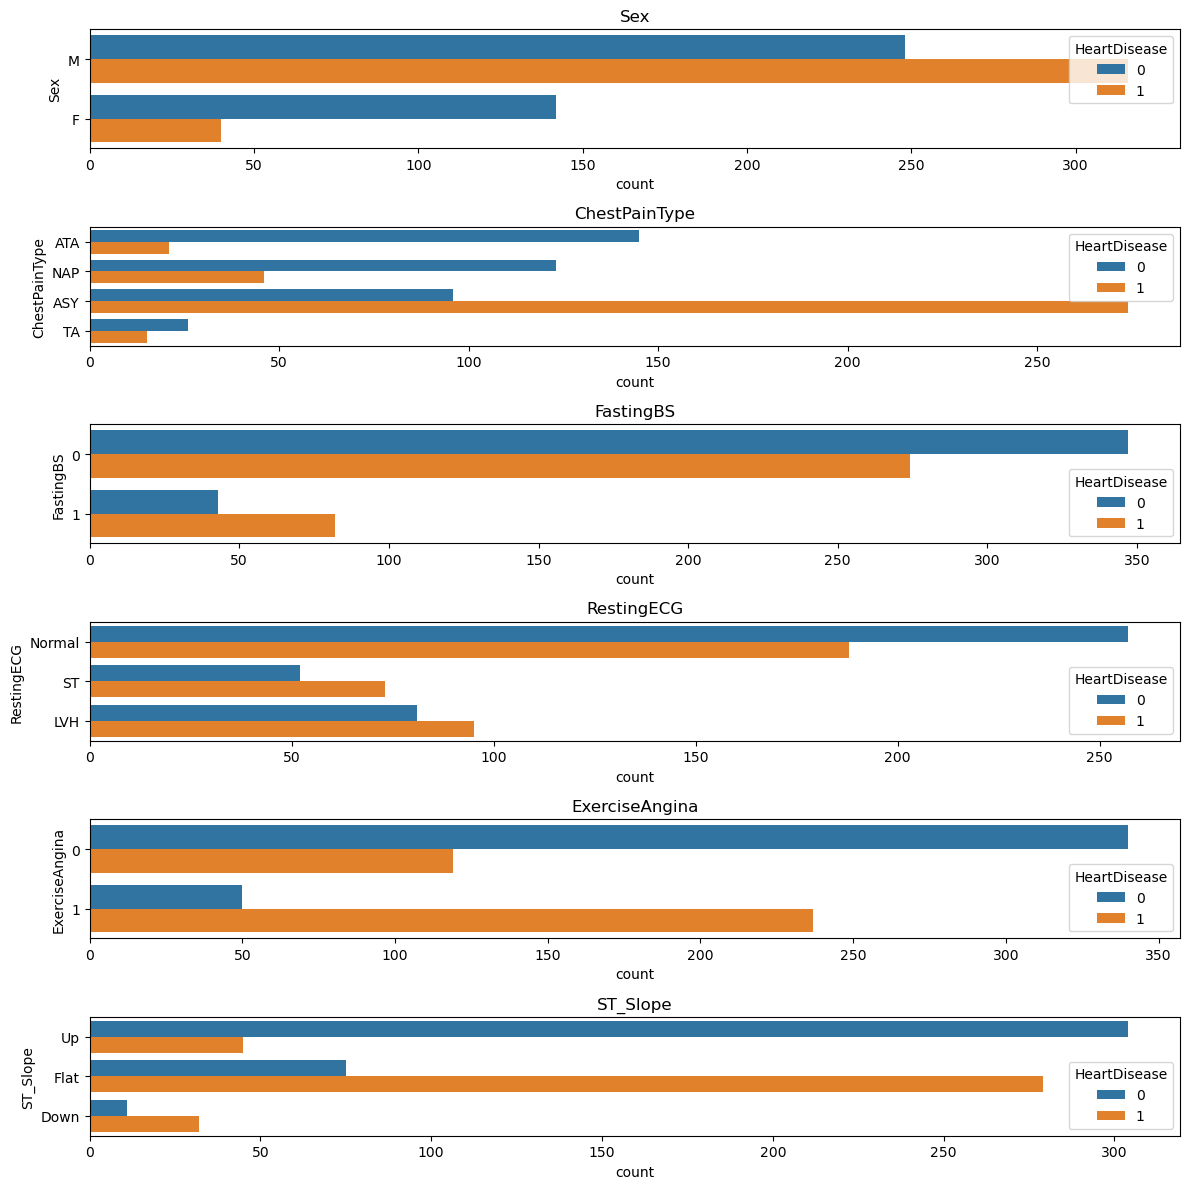

In [23]:
fig, ax = plt.subplots(6, 1, figsize=(12, 12))

for index, variable in enumerate(variables):
    seaborn.countplot(data=heart_data, y=variable, hue="HeartDisease", ax=ax[index])
    ax[index].set_title(variable)

fig.tight_layout()

In [53]:
p_values = pandas.DataFrame([])

for variable in variables:
    cont_table = pandas.crosstab(heart_data[variable], heart_data['HeartDisease'])
    stat, pval, _, _ = chi2_contingency(cont_table)
    p_values = pandas.concat([p_values, pandas.DataFrame({"p-value": pval}, index=[variable])])

p_values.sort_values("p-value", inplace=True)
p_values

,p-value
ST_Slope,5.013555e-70
ExerciseAngina,7.690036e-51
ChestPainType,2.199658e-46
Sex,2.546612e-15
FastingBS,1.801490e-05
RestingECG,9.979468e-04


It is readily apparent that ChestPainType, ExerciseAngina, ST_Slope are quite strongly correlated to HeartDisease.

Sex, FastingBS and RestingECG also seem to be correlated

### Create test split

In [4]:
x = heart_data.loc[:, ["Sex", "ChestPainType", "Cholesterol", "FastingBS", "ExerciseAngina", "Oldpeak", "ST_Slope"]]
x = pandas.get_dummies(x, columns=["Sex", "ChestPainType", "ST_Slope"])

y = heart_data["HeartDisease"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)